[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kevin7261/Geographic-Data-Science-with-Python/blob/main/Choropleth_Mapping.ipynb)

# Choropleth Mapping

https://geographicdata.science/book/notebooks/05_choropleth.html


In [1]:
# @title 初始值設定

PROJECT_NAME = "14_15_23_台南市區_合併位置_2" #"14_15_23_台南市區_合併位置_1"
GEOJSON_NAME = "台南市區_2"

DENGUE_DAILY_GSHEET_PATH = "https://docs.google.com/spreadsheets/d/1vYyoq0Vf07kuWJU0Rg375jpHT9r9WzA2jiCPl3V3Oi4/edit?gid=2026372005#gid=2026372005"
GEOJSON_FILE_PATH = "https://drive.google.com/file/d/19HAcRgd1o3KYugAIgcnM3xKN6ybUQ2RX/view?usp=sharing" #"https://drive.google.com/file/d/1SImPP3lj5ksvlcTQnEddtbpbZnIh1Jv8/view?usp=sharing"
WORKSHEET_NAME = PROJECT_NAME

In [2]:
# @title 下載台北思源黑體

# 下載台北思源黑體，並隱藏輸出
!wget -q -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 匯入必要的庫
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 新增字體
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')

# 設定字體
mpl.rc('font', family='Taipei Sans TC Beta')


In [3]:
# @title 安裝套件

!pip install -q geopandas gdown pysal

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.1/243.1 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━

---

# Principles

In [4]:
# @title 匯入函式庫

import seaborn
import pandas
import geopandas
import pysal
import numpy
import matplotlib.pyplot as plt

## 資料集

1. 2015年台南市登革熱病例 (xlsx)
1. 台南市最小統計區 (shp)

In [5]:
# @title 載入台南市登革熱病例(gsheet)

# ✅ 匯入套件
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
from gspread_dataframe import get_as_dataframe

SPREADSHEET_ID_GSHEET = DENGUE_DAILY_GSHEET_PATH.split("/d/")[1].split("/")[0]

# ✅ 認證授權
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# ✅ 開啟工作表
sh = gc.open_by_key(SPREADSHEET_ID_GSHEET)
worksheet = sh.worksheet(WORKSHEET_NAME)

# ✅ 將工作表轉為 DataFrame
ref = get_as_dataframe(worksheet)  # 可加入 index_col="name" 如欄位存在

ref.set_index("name", inplace=True)

# ✅ 預覽資料
ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, A0902-09 to A6735-54
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   count_14  431 non-null    float64
 1   count_15  431 non-null    float64
 2   count_23  431 non-null    float64
dtypes: float64(3)
memory usage: 13.5+ KB


In [6]:
# @title 下載geojson

import gdown

# ✅ 從 Google Drive 分享連結中提取檔案 ID
file_id = GEOJSON_FILE_PATH.split("/d/")[1].split("/")[0]

# ✅ 建立 direct download 連結
download_url = f"https://drive.google.com/uc?id={file_id}"

# ✅ 執行下載（保留原始檔名）
gdown.download(download_url, quiet=False)  # 不指定 output，就會用原檔名

# ✅ 驗證是否下載成功
import os
downloaded_files = os.listdir()
print("📂 當前目錄檔案：", downloaded_files)

Downloading...
From: https://drive.google.com/uc?id=19HAcRgd1o3KYugAIgcnM3xKN6ybUQ2RX
To: /content/台南市區_2.geojson
100%|██████████| 1.35M/1.35M [00:00<00:00, 65.2MB/s]

📂 當前目錄檔案： ['.config', 'TaipeiSansTCBeta-Regular.ttf', '台南市區_2.geojson', 'sample_data']


In [7]:
# @title 載入台南市最小統計區(geojson)

lads = geopandas.read_file(
    f"{GEOJSON_NAME}.geojson",
).set_index("CODE2")

lads["name"] = lads.index

lads.info()

#print(lads.crs) # EPSG:4979 Geodetic 3D coordinate system

lads.set_crs(epsg=3826, inplace=True, allow_override=True) # EPSG:3826 TWD97

print(lads.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 261 entries, A6733-22 to A6736-21
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   TOWN_ID    261 non-null    object  
 1   TOWN       261 non-null    object  
 2   COUNTY_ID  261 non-null    object  
 3   COUNTY     261 non-null    object  
 4   U_ID       261 non-null    int32   
 5   AREA       261 non-null    float64 
 6   X          261 non-null    float64 
 7   Y          261 non-null    float64 
 8   geometry   261 non-null    geometry
 9   name       261 non-null    object  
dtypes: float64(3), geometry(1), int32(1), object(5)
memory usage: 21.4+ KB
EPSG:3826


# 分析count欄位

In [8]:
# @title 用index欄位合併csv與shp

mx = (
    geopandas.GeoDataFrame(
        # ✅ 保留原有 X/Y 欄位並合併計數資料
        lads[["name", "X", "Y", "geometry"]].join(ref[["count_14", "count_15", "count_23"]], how="left"),
        crs=lads.crs
    )
    .to_crs(epsg=3857)[  # ✅ 投影轉換為 Web Mercator
        ["name", "X", "Y", "count_14", "count_15", "count_23", "geometry"]
    ]
    .fillna({  # ✅ 空值補 0
        "count_14": 0,
        "count_15": 0,
        "count_23": 0
    })
)

# ✅ 將 count 欄位轉為 int
for col in ["count_14", "count_15", "count_23"]:
    mx[col] = mx[col].astype(int)

# ✅ 預覽結果
mx.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 261 entries, A6733-22 to A6736-21
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   name      261 non-null    object  
 1   X         261 non-null    float64 
 2   Y         261 non-null    float64 
 3   count_14  261 non-null    int64   
 4   count_15  261 non-null    int64   
 5   count_23  261 non-null    int64   
 6   geometry  261 non-null    geometry
dtypes: float64(2), geometry(1), int64(3), object(1)
memory usage: 24.4+ KB


# Quantitative data classification

In [9]:
mx[["count_14", "count_15", "count_23"]].head()
mx

,name,X,Y,count_14,count_15,count_23,geometry
CODE2,,,,,,,
A6733-22,A6733-22,167003.0921,2.541249e+06,0,109,125,"POLYGON Z ((13379631.117 2628584.054 0, 133796..."
A6733-23,A6733-23,169361.5888,2.541144e+06,0,65,58,"POLYGON Z ((13382359.823 2628172.595 0, 133823..."
A6733-24,A6733-24,166584.0934,2.541065e+06,0,74,74,"POLYGON Z ((13379092.821 2628406.595 0, 133791..."
A6733-25,A6733-25,169124.5956,2.540906e+06,1,85,54,"POLYGON Z ((13381871.724 2628191.144 0, 133818..."
A6735-06,A6735-06,169816.9069,2.552237e+06,0,11,16,"POLYGON Z ((13382564.537 2640974.613 0, 133825..."
...,...,...,...,...,...,...,...
A6736-17,A6736-17,164752.9079,2.543379e+06,0,29,17,"POLYGON Z ((13377266.512 2630744.591 0, 133772..."
A6736-18,A6736-18,164989.4374,2.543164e+06,2,36,17,"POLYGON Z ((13377799.548 2630741.388 0, 133777..."
A6736-19,A6736-19,164524.5332,2.543141e+06,1,29,33,"POLYGON Z ((13377081.257 2630510.211 0, 133770..."


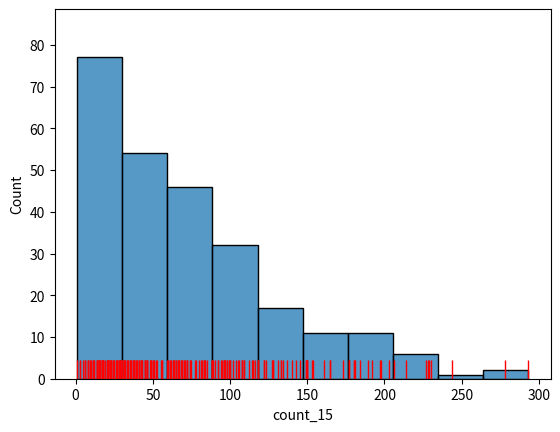

In [10]:
# Plot histogram
filtered = mx[mx["count_15"] > 0]

ax = seaborn.histplot(filtered["count_15"], bins=10)
# Add rug on horizontal axis
seaborn.rugplot(filtered["count_15"], height=0.05, color="red", ax=ax);

In [11]:
mx["count_15"].describe()

,count_15
count,261.000000
mean,70.563218
std,57.878062
min,0.000000
25%,27.000000
50%,53.000000
75%,99.000000
max,293.000000


In [12]:
counts, bins, patches = ax.hist(mx["count_15"], bins=5)

In [13]:
counts # 數量

array([134.,  79.,  28.,  17.,   3.])

In [14]:
bins # 斷點

array([  0. ,  58.6, 117.2, 175.8, 234.4, 293. ])

In [15]:
import mapclassify

## Equal intervals

In [16]:
ei5 = mapclassify.EqualInterval(mx["count_15"], k=5)
ei5

EqualInterval

    Interval       Count
------------------------
[  0.00,  58.60] |   134
( 58.60, 117.20] |    79
(117.20, 175.80] |    28
(175.80, 234.40] |    17
(234.40, 293.00] |     3

## Quantiles 分位數

In [17]:
q5 = mapclassify.Quantiles(mx.count_15, k=5)
q5

Quantiles

    Interval       Count
------------------------
[  0.00,  21.00] |    55
( 21.00,  40.00] |    50
( 40.00,  70.00] |    52
( 70.00, 112.00] |    52
(112.00, 293.00] |    52

In [18]:
q5.bins[1:] - q5.bins[:-1]

array([ 19.,  30.,  42., 181.])

In [19]:
# 隨機產生資料

# Set seed for reproducibility
numpy.random.seed(12345)
# Generate a variable of 20 values randomly
# selected from 0 to 10
x = numpy.random.randint(0, 10, 20)
# Manually ensure the first ten values are 0 (the
# minimum value)
x[0:10] = x.min()
x

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 7, 6, 0, 2, 9, 1, 2, 6, 7])

In [20]:
ties = mapclassify.Quantiles(x, k=5)
ties

/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


Quantiles

  Interval     Count
--------------------
[0.00, 0.00] |    11
(0.00, 1.40] |     1
(1.40, 6.20] |     4
(6.20, 9.00] |     4

In [21]:
ux = numpy.unique(x)
ux

array([0, 1, 2, 6, 7, 9])

## Mean-standard deviation 平均標準差

In [22]:
msd = mapclassify.StdMean(mx["count_15"])
msd

StdMean

    Interval       Count
------------------------
(  -inf, -45.19] |     0
(-45.19,  12.69] |    22
( 12.69, 128.44] |   200
(128.44, 186.32] |    25
(186.32, 293.00] |    14

## Maximum breaks

In [23]:
mb5 = mapclassify.MaximumBreaks(mx["count_15"], k=5)
mb5

MaximumBreaks

    Interval       Count
------------------------
[  0.00, 220.50] |   254
(220.50, 237.00] |     4
(237.00, 261.00] |     1
(261.00, 285.50] |     1
(285.50, 293.00] |     1

## Boxplot

In [24]:
bp = mapclassify.BoxPlot(mx["count_15"])
bp

BoxPlot

    Interval       Count
------------------------
(  -inf, -81.00] |     0
(-81.00,  27.00] |    69
( 27.00,  53.00] |    62
( 53.00,  99.00] |    66
( 99.00, 207.00] |    56
(207.00, 293.00] |     8

In [25]:
bp1 = mapclassify.BoxPlot(mx["count_15"], hinge=1)
bp1

BoxPlot

    Interval       Count
------------------------
(  -inf, -45.00] |     0
(-45.00,  27.00] |    69
( 27.00,  53.00] |    62
( 53.00,  99.00] |    66
( 99.00, 171.00] |    43
(171.00, 293.00] |    21

## Head-tail breaks

In [26]:
ht = mapclassify.HeadTailBreaks(mx["count_15"])
ht

HeadTailBreaks

    Interval       Count
------------------------
[  0.00,  70.56] |   157
( 70.56, 127.89] |    63
(127.89, 177.51] |    23
(177.51, 214.06] |    11
(214.06, 247.00] |     5
(247.00, 285.50] |     1
(285.50, 293.00] |     1

## Jenks-Caspall breaks

In [27]:
numpy.random.seed(12345)
jc5 = mapclassify.JenksCaspall(mx["count_15"], k=5)
jc5

JenksCaspall

    Interval       Count
------------------------
[  0.00,  26.00] |    65
( 26.00,  53.00] |    66
( 53.00,  85.00] |    45
( 85.00, 140.00] |    52
(140.00, 293.00] |    33

## Fisher-Jenks breaks

In [28]:

numpy.random.seed(12345)
fj5 = mapclassify.FisherJenks(mx["count_15"], k=5)
fj5

FisherJenks

    Interval       Count
------------------------
[  0.00,  38.00] |   101
( 38.00,  78.00] |    66
( 78.00, 128.00] |    55
(128.00, 192.00] |    27
(192.00, 293.00] |    12

## Max-p

In [29]:
mp5 = mapclassify.MaxP(mx["count_15"], k=5)
mp5

MaxP

    Interval       Count
------------------------
[  0.00,  22.00] |    57
( 22.00,  69.00] |    99
( 69.00,  70.00] |     1
( 70.00, 115.00] |    55
(115.00, 293.00] |    49

## Comparing classification schemes

<ipython-input-30-bd4591d25ded>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = seaborn.barplot(


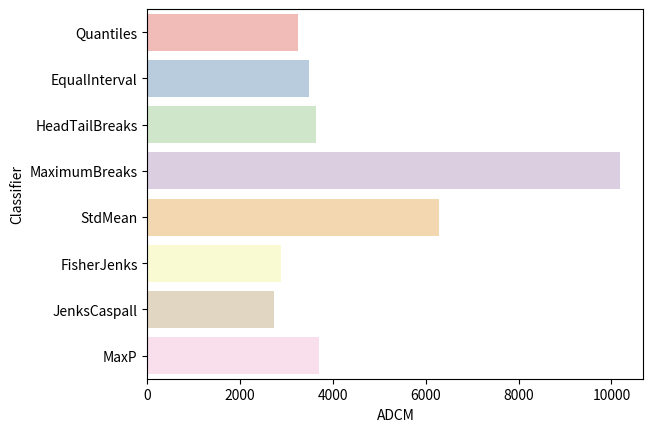

In [30]:
# 計算ADCM (absolute deviation around class medians)，越低越好

# Bunch classifier objects
class5 = q5, ei5, ht, mb5, msd, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = numpy.array([c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pandas.DataFrame(fits)
# Add classifier names
adcms["classifier"] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ["ADCM", "Classifier"]
ax = seaborn.barplot(
    y="Classifier", x="ADCM", data=adcms, palette="Pastel1"
)

In [31]:
# Append class values as a separate column
mx["Quantiles"] = q5.yb
mx["Equal Interval"] = ei5.yb
mx["Head-Tail Breaks"] = ht.yb
mx["Maximum Breaks"] = mb5.yb
mx["Mean-Standard Deviation"] = msd.yb
mx["Fisher-Jenks"] = fj5.yb
mx["Jenks Caspall"] = jc5.yb
mx["MaxP"] = mp5.yb

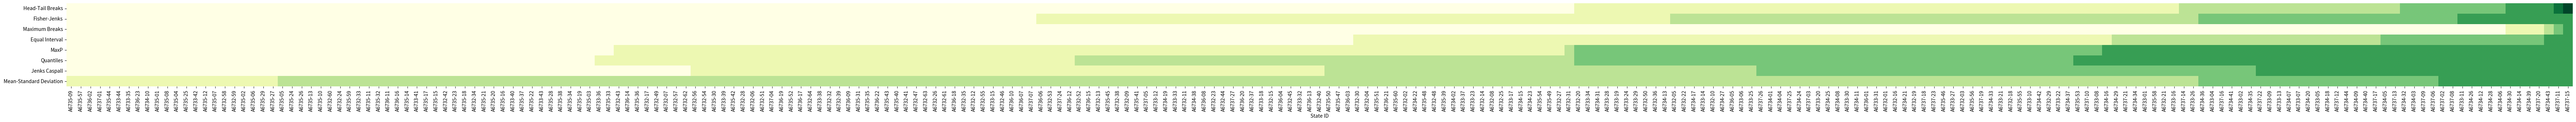

In [32]:
#f, ax = plt.subplots(1, figsize=(9, 3))
f, ax = plt.subplots(1, figsize=(90, 3))
seaborn.heatmap(
    mx.set_index("name")
    .sort_values("count_15")[
        [
            "Head-Tail Breaks",
            "Fisher-Jenks",
            "Maximum Breaks",
            "Equal Interval",
            "MaxP",
            "Quantiles",
            "Jenks Caspall",
            "Mean-Standard Deviation",
        ]
    ]
    .T,
    cmap="YlGn",
    cbar=False,
    ax=ax,
)
ax.set_xlabel("State ID");

In [33]:
# ✅ 建立修正後的 class5，確保每個 c.counts 長度為 5（多的截斷、少的補 NaN）
class5_fixed = []

for c in class5:
    counts = list(c.counts)
    # 若群數少於 5 → 補 NaN
    while len(counts) < 5:
        counts.append(float("nan"))
    # 若群數多於 5 → 截斷
    counts = counts[:5]

    # 模擬一個物件，具有 c.name 和截斷後 counts 屬性
    class Fixed:
        pass

    fixed = Fixed()
    fixed.name = c.name
    fixed.counts = counts
    class5_fixed.append(fixed)

# ✅ 完全照你要求的寫法建立表格
pandas.DataFrame(
    {c.name: c.counts for c in class5_fixed},
    index=["Class-{}".format(i) for i in range(5)],
)

,Quantiles,EqualInterval,HeadTailBreaks,MaximumBreaks,StdMean,FisherJenks,JenksCaspall,MaxP
Class-0,55,134,157,254,0,101,65,57
Class-1,50,79,63,4,22,66,66,99
Class-2,52,28,23,1,200,55,45,1
Class-3,52,17,11,1,25,27,52,55
Class-4,52,3,5,1,14,12,33,49


In [34]:
# pandas.DataFrame(
#     {c.name: c.counts for c in class5},
#     index=["Class-{}".format(i) for i in range(5)],
# )

# Color

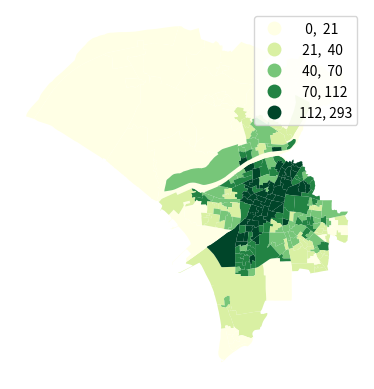

In [35]:
ax = mx.plot(
    column="count_15",  # Data to plot
    scheme="Quantiles",  # Classification scheme
    cmap="YlGn",  # Color palette
    legend=True,  # Add legend
    legend_kwds={"fmt": "{:.0f}"},  # Remove decimals in legend
)
ax.set_axis_off();

## Sequential palettes

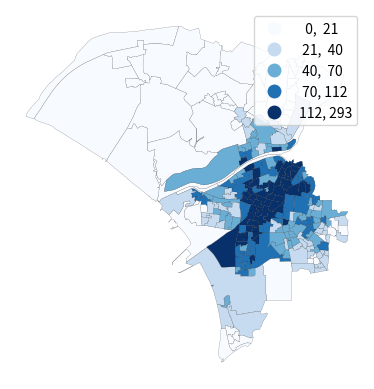

In [36]:
ax = mx.plot(
    column="count_15",  # Data to plot
    scheme="Quantiles",  # Classification scheme
    cmap="Blues",  # Color palette
    edgecolor="k",  # Borderline color
    linewidth=0.1,  # Borderline width
    legend=True,  # Add legend
    legend_kwds={
        "fmt": "{:.0f}"
    },  # Remove decimals in legend (for legibility)
)
ax.set_axis_off();

## Diverging palettes

In [37]:
# Create income-based rank table (Rank 1 is highest)
rnk = mx[["count_14", "count_15", "count_23"]].rank(ascending=False)
# Compute change from count_15 to count_14
rnk["change"] = rnk["count_15"] - rnk["count_14"]
# Add column with bin class
rnk["class"] = pandas.cut(rnk["change"], [-numpy.inf, -5, 0, 5, numpy.inf])

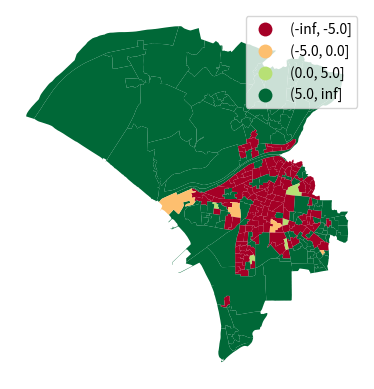

In [38]:
ax = (
    mx[["geometry"]]
    .join(rnk)
    .plot("class", legend=True, cmap="RdYlGn")
)
ax.set_axis_off();

## Qualitative palettes

In [39]:
mx["JenksCaspall"] = jc5.yb # 儲存count_15分類

In [40]:
mx["JenksCaspall"].head()

,JenksCaspall
CODE2,
A6733-22,3
A6733-23,2
A6733-24,2
A6733-25,2
A6735-06,0


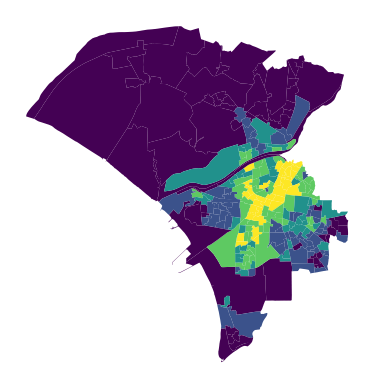

In [41]:
ax = mx.plot("JenksCaspall")
ax.set_axis_off();

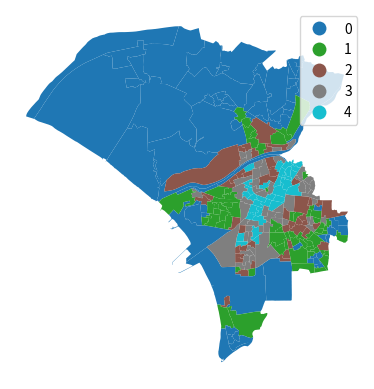

In [42]:
ax = mx.plot("JenksCaspall", categorical=True, legend=True)
ax.set_axis_off();

# Advanced topics

## User-defined choropleths

In [43]:
classi = mapclassify.UserDefined(
    #mx["count_14"], [10000, 12500, 15000]
    mx["count_23"], [0, 100, 200]
)
classi

UserDefined

    Interval       Count
------------------------
[  0.00,   0.00] |     6
(  0.00, 100.00] |   217
(100.00, 200.00] |    37
(200.00, 201.00] |     1

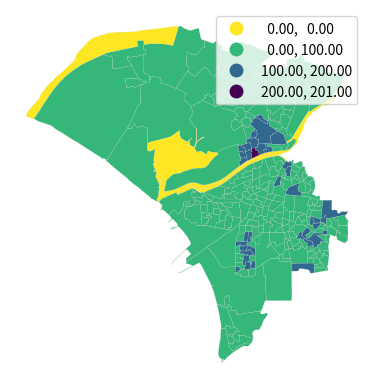

In [44]:
classi.plot(
    mx,  # Use geometries in the geo-table
    legend=True,  # Add a legend
    legend_kwds={
        "loc": "upper right"
    },  # Place legend on top right corner
    axis_on=False,  # Remove axis
    cmap="viridis_r",  # Use reverse Viridis
);

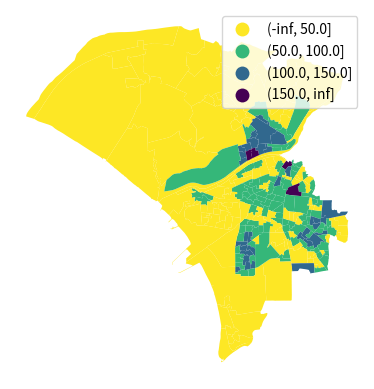

In [45]:
# Classify values specifying bins
lbls = pandas.cut(
    #mx["count_14"], [-numpy.inf, 10000, 12500, 15000, numpy.inf]
    mx["count_23"], [-numpy.inf, 50, 100, 150, numpy.inf]
)
# Dynamically assign to geo-table and plot with a legend
ax = mx.plot(lbls, cmap="viridis_r", legend=True)
# Remove axis
ax.set_axis_off();

## Pooled classifications

In [46]:
# List the years we want of pc GDP
years = ["count_14", "count_15", "count_23"]
# Create pooled classification
pooled = mapclassify.Pooled(mx[years], classifier="Quantiles", k=5)

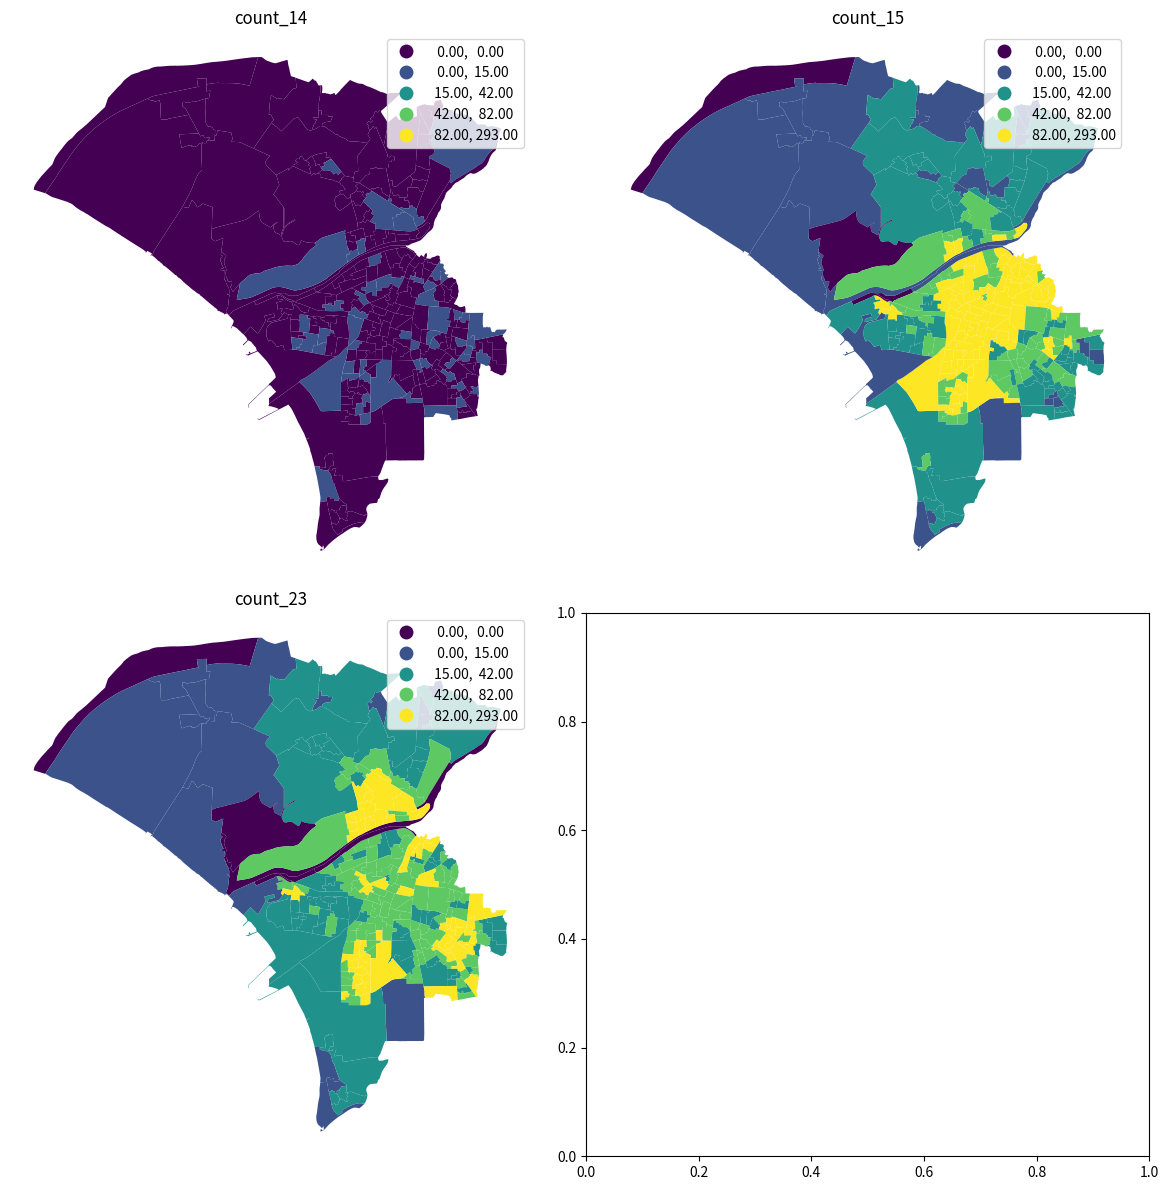

In [47]:
# Set up figure with four axis
f, axs = plt.subplots(2, 2, figsize=(12, 12))
# Flatten the array of axis so you can loop over
# in one dimension
axs = axs.flatten()
# Loop over each year
for i, y in enumerate(years):
    mx.plot(
        y,  # Year to plot
        scheme="UserDefined",  # Use our own bins
        classification_kwds={
            "bins": pooled.global_classifier.bins
        },  # Use global bins
        legend=True,  # Add a legend
        ax=axs[i],  # Plot on the corresponding axis
    )
    # Remove axis
    axs[i].set_axis_off()
    # Name the subplot with the name of the column
    axs[i].set_title(y)
# Tight layout to better use space
plt.tight_layout()
# Display figure
plt.show()